# **Problem Statement**

Build a Recommender System for an Indian subscription video on-demand and over-the-top streaming service, to show personalized movie recommendations based on ratings given by a user and other users similar to them based on user attributes like Age, Gender & Occupation in order to improve user experience.

In [226]:
#importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
from cmfrec import CMF
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_percentage_error as mape
from scipy.sparse import csr_matrix
from numpy import array
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [19]:
#importing data set

movies = pd.read_fwf('movies.dat', encoding='ISO-8859-1')
ratings = pd.read_fwf('ratings.dat', encoding='ISO-8859-1')
users = pd.read_fwf('users.dat', encoding='ISO-8859-1')

In [20]:
#formtting data file movies

movies.head()

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [21]:
movies.columns

Index(['Movie ID::Title::Genres', 'Unnamed: 1', 'Unnamed: 2'], dtype='object')

In [22]:
delimitter = '::'
movies = movies['Movie ID::Title::Genres'].str.split(delimitter, expand=True)
movies.columns = ['MovieID', 'Title', 'Genres']
movies.head(2)

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy


In [23]:
#formtting data file ratings

ratings.head()

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [24]:
ratings.columns

Index(['UserID::MovieID::Rating::Timestamp'], dtype='object')

In [25]:
delimitter = '::'
ratings = ratings['UserID::MovieID::Rating::Timestamp'].str.split(delimitter, expand=True)
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings.head(2)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109


In [26]:
#formtting data file users

users.head()

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


In [27]:
users.columns

Index(['UserID::Gender::Age::Occupation::Zip-code'], dtype='object')

In [28]:
delimitter = '::'
users = users['UserID::Gender::Age::Occupation::Zip-code'].str.split(delimitter, expand=True)
users.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
users.head(2)

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072


In [29]:
#movies data overiew

movies.shape

(3883, 3)

In [30]:
#non-null counts and data types

movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  3883 non-null   object
 1   Title    3883 non-null   object
 2   Genres   3858 non-null   object
dtypes: object(3)
memory usage: 91.1+ KB


In [31]:
#percentage of null values in each column

movies.isnull().sum()*100/movies.isnull().count()

MovieID    0.000000
Title      0.000000
Genres     0.643832
dtype: float64

In [32]:
#number of unique values

movies.nunique()

MovieID    3883
Title      3883
Genres      360
dtype: int64

In [33]:
#ratings data overiew

ratings.shape

(1000209, 4)

In [34]:
#non-null counts and data types

ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   UserID     1000209 non-null  object
 1   MovieID    1000209 non-null  object
 2   Rating     1000209 non-null  object
 3   Timestamp  1000209 non-null  object
dtypes: object(4)
memory usage: 30.5+ MB


In [35]:
#percentage of null values in each column

ratings.isnull().sum()*100/ratings.isnull().count()

UserID       0.0
MovieID      0.0
Rating       0.0
Timestamp    0.0
dtype: float64

In [36]:
#number of unique values

ratings.nunique()

UserID         6040
MovieID        3706
Rating            5
Timestamp    458455
dtype: int64

In [37]:
#users data overiew

users.shape

(6040, 5)

In [38]:
#non-null counts and data types

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   object
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   object
 3   Occupation  6040 non-null   object
 4   Zip-code    6040 non-null   object
dtypes: object(5)
memory usage: 236.1+ KB


In [39]:
#percentage of null values in each column

users.isnull().sum()*100/users.isnull().count()

UserID        0.0
Gender        0.0
Age           0.0
Occupation    0.0
Zip-code      0.0
dtype: float64

In [40]:
#number of unique values

users.nunique()

UserID        6040
Gender           2
Age              7
Occupation      21
Zip-code      3439
dtype: int64

**Data Overview**

1. **Movies**
    - There are 3883 rows and 3 columns in the dataset
    - Each row represents a movie and its features; MovieID, Title(and Release Year) and Genres
    - All the three columns are categorical variables of type object
    - 0.64% or 25 movies have null values for column genres<br><br>
    
2. **Users**
    - There are 6040 rows and 5 columns in the dataset
    - Each row represents a user and their features; UserID, Gender, Age, Occupation and Zip-code
    - All the five columns are categorical variables of type object
    - No missing values are present in the dataset<br><br>
    
3. **Ratings**
    - There are 1,000,209 rows and 4 columns in the dataset
    - Each row represents the rating, movie, the user who is rated and the timestamp
    - All the four columns are of type object however, rating and timestamp can be converted into numerical features
    - No missing values are present in the dataset

# **Exploratory Data Analysis**

In [41]:
#dropping 25 movies with no genres

movies = movies.dropna()
movies.shape

(3858, 3)

In [42]:
#creating new feature Release_year

movies['Release_year'] = movies['Title'].apply(lambda s: int(s.rstrip("*")[s.rfind("(")+1:-1]))

In [43]:
#creating movie_age feature from Release_year

movies['MovieAge'] = movies['Release_year'].apply(lambda x: 2022 - int(x))
movies.head(2)

,MovieID,Title,Genres,Release_year,MovieAge
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,27
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,27


In [44]:
#converting timestamp to hour and ratings to int type

ratings['Rating'] = ratings['Rating'].astype('int')
ratings['Hour'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(int(x)).hour)
ratings.head(2)

,UserID,MovieID,Rating,Timestamp,Hour
0,1,1193,5,978300760,3
1,1,661,3,978302109,4


In [45]:
#converting US zip codes to city codes

users['Zip-code'] = users['Zip-code'].apply(lambda x: x[:3])
users.head(2)

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,480
1,2,M,56,16,700


In [46]:
#merging movies and ratings

df = pd.merge(movies, ratings, on='MovieID')
df.head(2)

,MovieID,Title,Genres,Release_year,MovieAge,UserID,Rating,Timestamp,Hour
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,27,1,5,978824268,5
1,1,Toy Story (1995),Animation|Children's|Comedy,1995,27,6,4,978237008,10


In [47]:
#merging df and users

df = pd.merge(df, users, on='UserID')
df.head(2)

,MovieID,Title,Genres,Release_year,MovieAge,UserID,Rating,Timestamp,Hour,Gender,Age,Occupation,Zip-code
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,27,1,5,978824268,5,F,1,10,480
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1995,27,1,5,978824351,5,F,1,10,480


In [48]:
df.shape

(996144, 13)

In [49]:
#min number of ratings for a user

df.groupby(['UserID'])['MovieID'].count().min()

19

In [50]:
#number of unique values

df.nunique()

MovieID           3682
Title             3682
Genres             358
Release_year        81
MovieAge            81
UserID            6040
Rating               5
Timestamp       457632
Hour                24
Gender               2
Age                  7
Occupation          21
Zip-code           678
dtype: int64

In [51]:
df.describe()

,Release_year,MovieAge,Rating,Hour
count,996144.000000,996144.000000,996144.000000,996144.000000
mean,1986.758458,35.241542,3.579985,9.730529
std,14.314470,14.314470,1.116849,7.293934
min,1919.000000,22.000000,1.000000,0.000000
25%,1982.000000,25.000000,3.000000,4.000000
50%,1992.000000,30.000000,4.000000,8.000000
75%,1997.000000,40.000000,4.000000,15.000000
max,2000.000000,103.000000,5.000000,23.000000


In [52]:
#splitting genres to get different genres

m = movies.copy()
m['Genres'] = m['Genres'].str.split('|')
m = m.explode('Genres')
m = m.pivot(index='MovieID', columns='Genres', values='Title')
m = ~m.isna()
m = m.astype(int)
m.head(2)

Genres,,A,Acti,Action,Adv,Advent,Adventu,Adventur,Adventure,Animati,...,Sci-Fi,Th,Thri,Thrille,Thriller,Wa,War,We,Wester,Western
MovieID,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [53]:
#cleaning genres for consistency

m['action'] = m[['A', 'Acti', 'Action']].agg(sum, axis=1)
m['adventure'] = m[['Adv', 'Advent', 'Adventu', 'Adventur', 'Adventure']].agg(sum, axis=1)
m['animation'] = m[['Animati', 'Animation']].agg(sum, axis=1)
m['childrens'] = m[['Chi', 'Chil', 'Childr', 'Childre', 'Children', "Children'", "Children's"]].agg(sum, axis=1)
m['comedy'] = m[['Com', 'Come', 'Adventu', 'Comed', 'Comedy']].agg(sum, axis=1)
m['crime'] = m[['Crime']].agg(sum, axis=1)
m['documentary'] = m[['D', 'Docu', 'Documen', 'Document', 'Documentary']].agg(sum, axis=1)
m['drama'] = m[['Dr', 'Dram', 'Drama']].agg(sum, axis=1)
m['fantasy'] = m[['F', 'Fant', 'Fantas', 'Fantasy']].agg(sum, axis=1)
m['film-noir'] = m[['Film-Noir']].agg(sum, axis=1)
m['horror'] = m[['Horr', 'Horro', 'Horror']].agg(sum, axis=1)
m['musical'] = m[['Music', 'Musical']].agg(sum, axis=1)
m['mystery'] = m[['Mystery']].agg(sum, axis=1)
m['romance'] = m[['R', 'Ro', 'Rom', 'Roma', 'Roman', 'Romance']].agg(sum, axis=1)
m['sci-fi'] = m[['S', 'Sci', 'Sci-', 'Sci-F', 'Sci-Fi']].agg(sum, axis=1)
m['thriller'] = m[['Th', 'Thri', 'Thrille', 'Thriller']].agg(sum, axis=1)
m['war'] = m[['Wa', 'War']].agg(sum, axis=1)
m['western'] = m[['Wester', 'Western']].agg(sum, axis=1)
m = m.drop(columns=['', 'A', 'Acti', 'Action', 'Adv', 'Advent', 'Adventu', 'Adventur',
       'Adventure', 'Animati', 'Animation', 'Chi', 'Chil', 'Childr', 'Childre',
       'Children', "Children'", "Children's", 'Com', 'Come', 'Comed', 'Comedy',
       'Crime', 'D', 'Docu', 'Documen', 'Document', 'Documenta', 'Documentary',
       'Dr', 'Dram', 'Drama', 'F', 'Fant', 'Fantas', 'Fantasy', 'Film-Noir',
       'Horr', 'Horro', 'Horror', 'Music', 'Musical', 'Mystery', 'R', 'Ro',
       'Rom', 'Roma', 'Roman', 'Romance', 'S', 'Sci', 'Sci-', 'Sci-F',
       'Sci-Fi', 'Th', 'Thri', 'Thrille', 'Thriller', 'Wa', 'War', 'We',
       'Wester', 'Western'])
m.head(2)

Genres,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,film-noir,horror,musical,mystery,romance,sci-fi,thriller,war,western
MovieID,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [54]:
m.columns

Index(['action', 'adventure', 'animation', 'childrens', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'film-noir', 'horror', 'musical',
       'mystery', 'romance', 'sci-fi', 'thriller', 'war', 'western'],
      dtype='object', name='Genres')

In [55]:
#avg_rating and no.of rating by movies

movie_rating = ratings.groupby('MovieID').agg({'Rating':['mean', 'count']}).rename(
    columns={'mean':'rate_avg', 'count':'rate_ct'})
movie_rating.columns = movie_rating.columns.droplevel()

In [56]:
#merging m with movies and adding avg rating

movies_df = pd.merge(movies, m, on='MovieID')
movies_df = pd.merge(movies_df, movie_rating, on='MovieID')
movies_df.head(2)

,MovieID,Title,Genres,Release_year,MovieAge,action,adventure,animation,childrens,comedy,...,horror,musical,mystery,romance,sci-fi,thriller,war,western,rate_avg,rate_ct
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,27,0,0,1,1,1,...,0,0,0,0,0,0,0,0,4.146846,2077
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,27,0,1,0,1,0,...,0,0,0,0,0,0,0,0,3.201141,701


In [57]:
#checking column Release_year

movies_df['Release_year'].value_counts()

1998    313
1996    311
1995    310
1997    304
1999    271
       ... 
1928      2
1923      2
1922      1
1920      1
1921      1
Name: Release_year, Length: 81, dtype: int64

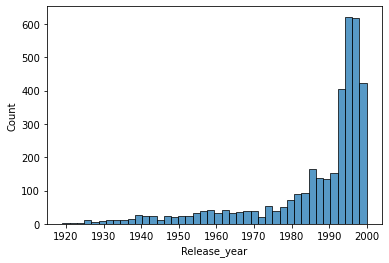

In [58]:
sns.histplot(data=movies_df, x='Release_year')
plt.show()

In [59]:
#checking genres count

cols = ['action', 'adventure', 'animation', 'childrens', 'comedy',
       'crime', 'documentary', 'drama', 'fantasy', 'film-noir', 'horror',
       'musical', 'mystery', 'romance', 'sci-fi', 'thriller', 'war',
       'western']
dic = {}
for col in cols:
    dic[col] = movies_df[col].sum()
dict(sorted(dic.items(), key=lambda item: item[1]))

{'film-noir': 44,
 'fantasy': 63,
 'western': 66,
 'mystery': 103,
 'animation': 104,
 'documentary': 108,
 'musical': 112,
 'war': 137,
 'crime': 200,
 'childrens': 248,
 'sci-fi': 263,
 'adventure': 280,
 'horror': 336,
 'romance': 450,
 'thriller': 482,
 'action': 495,
 'comedy': 1154,
 'drama': 1472}

In [60]:
#checking genres count post 2000

dic = {}
for col in cols:
    dic[col] = movies_df[movies_df['Release_year'] >= 2000][col].sum()
dict(sorted(dic.items(), key=lambda item: item[1]))

{'film-noir': 0,
 'western': 0,
 'fantasy': 1,
 'musical': 1,
 'mystery': 1,
 'war': 2,
 'adventure': 6,
 'documentary': 7,
 'animation': 8,
 'crime': 8,
 'horror': 8,
 'childrens': 9,
 'sci-fi': 10,
 'romance': 16,
 'action': 19,
 'thriller': 25,
 'drama': 53,
 'comedy': 67}

In [61]:
#Movies rated by most number of peoples

movies_df[['MovieID', 'Title','rate_ct', 'rate_avg']].sort_values(by='rate_ct', ascending=False).head(10)

,MovieID,Title,rate_ct,rate_avg
2635,2858,American Beauty (1999),3428,4.317386
251,260,Star Wars: Episode IV - A New Hope (1977),2991,4.453694
1097,1196,Star Wars: Episode V - The Empire Strikes Back...,2990,4.292977
1111,1210,Star Wars: Episode VI - Return of the Jedi (1983),2883,4.022893
462,480,Jurassic Park (1993),2672,3.763847
1837,2028,Saving Private Ryan (1998),2653,4.337354
571,589,Terminator 2: Judgment Day (1991),2649,4.058513
2362,2571,"Matrix, The (1999)",2590,4.315830
1169,1270,Back to the Future (1985),2583,3.990321
575,593,"Silence of the Lambs, The (1991)",2578,4.351823


In [62]:
#Movies with highest ratings and rated by atleast 10 people

movies_df[movies_df['rate_ct']>=10][['MovieID', 'Title','rate_ct', 'rate_avg']].sort_values(
    by='rate_avg', ascending=False).head(10)

,MovieID,Title,rate_ct,rate_avg
2682,2905,Sanjuro (1962),69,4.608696
307,318,"Shawshank Redemption, The (1994)",2227,4.554558
795,858,"Godfather, The (1972)",2223,4.524966
703,745,"Close Shave, A (1995)",657,4.520548
49,50,"Usual Suspects, The (1995)",1783,4.517106
509,527,Schindler's List (1993),2304,4.510417
1059,1148,"Wrong Trousers, The (1993)",882,4.507937
854,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),470,4.491489
1099,1198,Raiders of the Lost Ark (1981),2514,4.477725
836,904,Rear Window (1954),1050,4.476190


[]

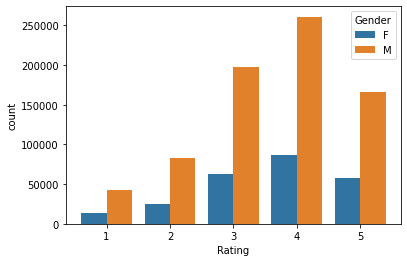

In [63]:
sns.countplot(data=df, x='Rating', hue='Gender')
plt.plot()

In [64]:
#checking users

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   object
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   object
 3   Occupation  6040 non-null   object
 4   Zip-code    6040 non-null   object
dtypes: object(5)
memory usage: 236.1+ KB


In [65]:
users['Gender'].value_counts()

M    4331
F    1709
Name: Gender, dtype: int64

In [66]:
users['Age'].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: Age, dtype: int64

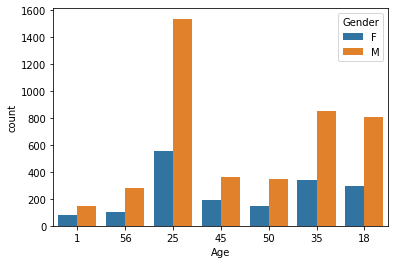

In [67]:
sns.countplot(data=users, x='Age', hue='Gender')
plt.show()

In [68]:
users['Occupation'].value_counts()

4     759
0     711
7     679
1     528
17    502
12    388
14    302
20    281
2     267
16    241
6     236
10    195
3     173
15    144
13    142
11    129
5     112
9      92
19     72
18     70
8      17
Name: Occupation, dtype: int64

In [69]:
users['Zip-code'].value_counts().head(10)

554    172
100    162
551    146
941    137
021    109
606    104
900    103
481     95
981     90
921     72
Name: Zip-code, dtype: int64

# **Build a Recommender System based on Pearson Correlation**

In [70]:
#creating item-user matrix

item_user = ratings.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
item_user.head()

MovieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
# item similarity matrix using Pearson correlation

item_sim = item_user.corr()

In [72]:
item_sim.shape

(3706, 3706)

**Query - List of 5 movies to recommend to a user who has liked 'The Shawshank Redemption (1994)' MovieID - 318**

In [73]:
movies[movies['MovieID']=='318']

,MovieID,Title,Genres,Release_year,MovieAge
315,318,"Shawshank Redemption, The (1994)",Drama,1994,28


In [74]:
print("Here is a list of 5 movies to recommend to a user who has liked 'Shawshank Redemption, The (1994)'")
lt = list(pd.DataFrame(item_sim['307'].sort_values(ascending=False).iloc[1:6]).index)
item_sim['307'].sort_values(ascending=False).iloc[1:6]

Here is a list of 5 movies to recommend to a user who has liked 'Shawshank Redemption, The (1994)'


MovieID
308     0.675480
306     0.593413
1176    0.298589
535     0.293932
194     0.272502
Name: 307, dtype: float64

In [75]:
movies[movies['MovieID'].isin(lt)]

,MovieID,Title,Genres,Release_year,MovieAge
192,194,Smoke (1995),Drama,1995,27
303,306,Three Colors: Red (1994),Drama,1994,28
305,308,Three Colors: White (1994),Drama,1994,28
531,535,Short Cuts (1993),Drama,1993,29


# **Build a Recommender System based on Cosine Similarity**

In [76]:
# Create user-item matrix

user_item = ratings.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
user_item.head()

MovieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
# User similarity matrix using cosine similarity

user_sim = cosine_similarity(user_item)
user_sim = pd.DataFrame(user_sim, index=user_item.index, columns=user_item.index)
user_sim

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.255288,0.123967,0.207800,0.139061,0.110320,0.121384,0.179143,0.103137,0.052816,...,0.079367,0.038048,0.032136,0.066641,0.070052,0.035731,0.170184,0.159267,0.119356,0.122059
10,0.255288,1.000000,0.258047,0.278753,0.154858,0.112222,0.141111,0.428224,0.188569,0.101856,...,0.153462,0.186086,0.083224,0.123288,0.117829,0.145650,0.300175,0.160346,0.132506,0.246251
100,0.123967,0.258047,1.000000,0.297539,0.075597,0.110450,0.358686,0.236065,0.171609,0.099147,...,0.098235,0.097953,0.065152,0.176048,0.271311,0.033754,0.344290,0.204302,0.113522,0.306104
1000,0.207800,0.278753,0.297539,1.000000,0.094710,0.047677,0.201722,0.353782,0.323584,0.130702,...,0.170100,0.076779,0.000000,0.197410,0.380741,0.044404,0.330748,0.172803,0.098456,0.245292
1001,0.139061,0.154858,0.075597,0.094710,1.000000,0.164551,0.053788,0.149019,0.137336,0.134462,...,0.146001,0.026842,0.096832,0.117641,0.092065,0.109499,0.221710,0.100597,0.269456,0.175194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.035731,0.145650,0.033754,0.044404,0.109499,0.072578,0.031406,0.088304,0.061001,0.032265,...,0.080559,0.252222,0.074207,0.097260,0.048650,1.000000,0.063925,0.019459,0.075830,0.052428
996,0.170184,0.300175,0.344290,0.330748,0.221710,0.224779,0.185226,0.349899,0.285861,0.164045,...,0.205186,0.086546,0.062523,0.183712,0.217672,0.063925,1.000000,0.174127,0.178834,0.417330
997,0.159267,0.160346,0.204302,0.172803,0.100597,0.068980,0.170771,0.171951,0.105527,0.049536,...,0.187734,0.030588,0.081380,0.160234,0.110656,0.019459,0.174127,1.000000,0.186575,0.182452


In [78]:
user_sim.shape

(6040, 6040)

**Query - List of 5 users similar to the user with userID - 1**

In [79]:
users[users['UserID']=='1']

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,480


In [80]:
print("Here is a list of 5 users similar to the user with userID - 1")
lt = list(pd.DataFrame(user_sim['1'].sort_values(ascending=False).iloc[1:6]).index)
user_sim['1'].sort_values(ascending=False).iloc[1:6]

Here is a list of 5 users similar to the user with userID - 1


UserID
5343    0.412117
5190    0.411899
1481    0.392110
1283    0.386597
5705    0.360898
Name: 1, dtype: float64

In [81]:
users[users['UserID'].isin(lt)]

,UserID,Gender,Age,Occupation,Zip-code
1282,1283,F,18,1,946
1480,1481,M,35,17,770
5189,5190,F,35,0,850
5342,5343,F,25,9,602
5704,5705,F,18,4,900


In [147]:
#item-based similarity matrix based on KNN and Cosine Similarity

movies_df.head(2)

,MovieID,Title,Genres,Release_year,MovieAge,action,adventure,animation,childrens,comedy,...,horror,musical,mystery,romance,sci-fi,thriller,war,western,rate_avg,rate_ct
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,27,0,0,1,1,1,...,0,0,0,0,0,0,0,0,4.146846,2077
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,27,0,1,0,1,0,...,0,0,0,0,0,0,0,0,3.201141,701


In [148]:
movies_train = movies_df.drop(columns=['MovieID', 'Title', 'Genres', 'Release_year'])
movies_train.head(2)

,MovieAge,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,...,horror,musical,mystery,romance,sci-fi,thriller,war,western,rate_avg,rate_ct
0,27,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,4.146846,2077
1,27,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,3.201141,701


In [149]:
movies_train.shape

(3682, 21)

In [150]:
##scaling data
scaler = StandardScaler()
scaler.fit(movies_train[movies_train.columns])
movies_cleaned = movies_train.copy()
X = scaler.transform(movies_train[movies_train.columns])  # returns numpy.ndarray not df.

X

array([[-0.53391391, -0.39318803, -0.28688766, ..., -0.13510075,
         1.35278064,  4.69953471],
       [-0.53391391, -0.39318803,  3.48568501, ..., -0.13510075,
        -0.05554765,  1.11984014],
       [-0.53391391, -0.39318803, -0.28688766, ..., -0.13510075,
        -0.33016022,  0.53970069],
       ...,
       [-0.83486474, -0.39318803, -0.28688766, ..., -0.13510075,
         0.63770502, -0.56334473],
       [-0.83486474, -0.39318803, -0.28688766, ..., -0.13510075,
         0.98518111, -0.59976604],
       [-0.83486474, -0.39318803, -0.28688766, ..., -0.13510075,
         0.80786084,  0.30556369]])

In [151]:
X.shape

(3682, 21)

In [152]:
# Item similarity matrix using cosine similarity

item_cosine_sim = cosine_similarity(X)
item_cosine_sim = pd.DataFrame(item_cosine_sim, index=movies_df.MovieID, columns=movies_df.MovieID)
item_cosine_sim

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
MovieID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.206599,0.101794,-0.088609,0.106230,0.094914,0.120728,0.208012,-0.202565,0.076562,...,-0.013932,-0.189909,0.572784,-0.237266,-0.188959,0.435081,-0.021710,-0.239761,-0.209562,-0.042877
2,0.206599,1.000000,-0.084843,-0.184710,-0.107904,-0.038795,-0.088067,0.534626,-0.080025,0.232783,...,-0.122053,-0.158240,0.331235,-0.122471,-0.112164,-0.013099,-0.101692,-0.147750,-0.141424,-0.100012
3,0.101794,-0.084843,1.000000,0.183101,0.451199,-0.139913,0.985042,-0.135685,-0.117981,-0.150532,...,0.405011,0.171313,-0.092069,-0.251443,-0.231757,0.416313,-0.257068,-0.302572,-0.301314,-0.257851
4,-0.088609,-0.184710,0.183101,1.000000,0.559063,-0.362684,0.130525,-0.191480,-0.142679,-0.369614,...,0.572021,0.944001,-0.078646,0.088001,-0.362420,0.283719,0.176128,0.330082,0.261922,0.018279
5,0.106230,-0.107904,0.451199,0.559063,1.000000,-0.205943,0.423882,-0.097538,0.017158,-0.214656,...,0.962020,0.524254,-0.067422,-0.260624,-0.166632,0.755764,-0.198856,-0.177010,-0.192284,-0.280474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0.435081,-0.013099,0.416313,0.283719,0.755764,0.063513,0.447125,-0.138885,-0.141203,0.034166,...,0.624767,0.111162,-0.186856,-0.350868,-0.218645,1.000000,0.102263,-0.132474,-0.099553,-0.052123
3949,-0.021710,-0.101692,-0.257068,0.176128,-0.198856,-0.072609,-0.161752,-0.136008,-0.190704,-0.134487,...,-0.129560,-0.001899,-0.279432,-0.054323,-0.137685,0.102263,1.000000,0.916195,0.945574,0.471604
3950,-0.239761,-0.147750,-0.302572,0.330082,-0.177010,-0.219685,-0.247340,-0.100236,-0.078653,-0.265525,...,-0.039764,0.249965,-0.188428,0.078499,-0.132408,-0.132474,0.916195,1.000000,0.989114,0.415434


In [153]:
item_cosine_sim.shape

(3682, 3682)

**Query - List of 5 movies to recommend to a user who has liked 'The Shawshank Redemption (1994)' MovieID - 318**

In [154]:
movies[movies['MovieID']=='318']

,MovieID,Title,Genres,Release_year,MovieAge,Decade
315,318,"Shawshank Redemption, The (1994)",Drama,1994,28,1990


In [155]:
print("Here is a list of 5 movies to recommend to a user who has liked 'Shawshank Redemption, The (1994)'")
lt = list(pd.DataFrame(item_cosine_sim['318'].sort_values(ascending=False).iloc[1:6]).index)
item_cosine_sim['318'].sort_values(ascending=False).iloc[1:6]

Here is a list of 5 movies to recommend to a user who has liked 'Shawshank Redemption, The (1994)'


MovieID
1704    0.986775
2959    0.977749
1961    0.975023
1225    0.971536
1193    0.968353
Name: 318, dtype: float64

In [91]:
movies[movies['MovieID'].isin(lt)]

,MovieID,Title,Genres,Release_year,MovieAge
1176,1193,One Flew Over the Cuckoo's Nest (1975),Drama,1975,47
1207,1225,Amadeus (1984),Drama,1984,38
1656,1704,Good Will Hunting (1997),Drama,1997,25
1892,1961,Rain Man (1988),Drama,1988,34
2890,2959,Fight Club (1999),Drama,1999,23


# **Build a Recommender System based on Matrix Factorization**

In [92]:
rm = ratings.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
rm.head()

MovieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
um_mf = ratings[['UserID', 'MovieID', 'Rating']].copy()
um_mf.columns = ['UserId', 'ItemId', 'Rating']  # Lib requires specific column names
um_mf.head(2)

,UserId,ItemId,Rating
0,1,1193,5
1,1,661,3


In [94]:
#Use cmfrec library to run matrix factorization. (Show results with d=4)

model = CMF(method="als", k=4, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)

In [95]:
model.fit(um_mf)

Collective matrix factorization model
(explicit-feedback variant)


In [96]:
model.A_.shape, model.B_.shape

((6040, 4), (3706, 4))

In [97]:
um_mf.Rating.mean(), model.glob_mean_

(3.581564453029317, 3.581564426422119)

In [98]:
#RMSE

rm__ = np.dot(model.A_, model.B_.T) + model.glob_mean_
mse(rm.values[rm > 0], rm__[rm > 0])**0.5

1.4183050661062944

In [99]:
#MAPE

mape(rm.values[rm > 0], rm__[rm > 0])

0.41151258874570046

In [100]:
ratings.loc[ratings.UserID=='1'].head()

,UserID,MovieID,Rating,Timestamp,Hour
0,1,1193,5,978300760,3
1,1,661,3,978302109,4
2,1,914,3,978301968,4
3,1,3408,4,978300275,3
4,1,2355,5,978824291,5


In [101]:
#Get d=2 embeddings, and plot the results

#Use cmfrec library to run matrix factorization. (Show results with d=2)

model = CMF(method="als", k=2, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)

In [102]:
model.fit(um_mf)

Collective matrix factorization model
(explicit-feedback variant)


In [103]:
model.A_.shape, model.B_.shape

((6040, 2), (3706, 2))

In [104]:
um_mf.Rating.mean(), model.glob_mean_

(3.581564453029317, 3.581564426422119)

In [105]:
#RMSE

rm__ = np.dot(model.A_, model.B_.T) + model.glob_mean_
mse(rm.values[rm > 0], rm__[rm > 0])**0.5

1.3570806112486162

In [106]:
#MAPE

mape(rm.values[rm > 0], rm__[rm > 0])

0.40771761654281075

# **Build a Recommender System based Pearson Correlation (Optional)**

In [184]:
#Ask the user to rate a few movies and create a dataframe of the user’s choices.
df_997 = df[df['UserID'] == '997']
df_997.head(2)

,MovieID,Title,Genres,Release_year,MovieAge,UserID,Rating,Timestamp,Hour,Gender,Age,Occupation,Zip-code
88414,1,Toy Story (1995),Animation|Children's|Comedy,1995,27,997,4,975205507,7,M,1,19,157
88415,34,Babe (1995),Children's|Comedy|Drama,1995,27,997,4,975205697,7,M,1,19,157


In [185]:
df_997.shape[0]

30

In [218]:
#Find other users who’ve watched the same movies as the new user.
m_lt = list(df_997['MovieID'].values)

In [219]:
#Sort the old users by the count of most movies in common with the new user.
#Take the top 100 users
u_lt = list(pd.DataFrame(df[df['MovieID'].isin(m_lt)].groupby('UserID')['MovieID'].count()).sort_values(
    by='MovieID', ascending=False).head(100).index)

In [240]:
#calculate a Similarity Score for each user using the Pearson Correlation function.
user_train = users[users['UserID'].isin(u_lt)]
user_train.head()

,UserID,Gender,Age,Occupation,Zip-code
47,48,M,25,4,921
194,195,M,25,12,104
300,301,M,18,4,618
301,302,M,18,4,049
307,308,M,25,2,100


In [241]:
#label encode features

le = LabelEncoder()
user_train['Gender'] = le.fit_transform(user_train['Gender'])

/tmp/ipykernel_195599/3818497058.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_train['Gender'] = le.fit_transform(user_train['Gender'])


In [242]:
user_train['Age'] = user_train['Age'].map(
{'1':15, '18':21, '25':30, '35':40, '45':47, '50':52, '56':60})

/tmp/ipykernel_195599/3605105142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_train['Age'] = user_train['Age'].map(


In [244]:
X_user = user_train.drop(columns=['UserID', 'Occupation', 'Zip-code'])
X_user.head()

,Gender,Age
47,1,30
194,1,30
300,1,21
301,1,21
307,1,30


In [248]:
##scaling data
scaler = StandardScaler()
scaler.fit(X_user[X_user.columns])
users_cleaned = X_user.copy()
X_u = scaler.transform(X_user[X_user.columns])  # returns numpy.ndarray not df.

X_u[:5]

array([[ 0.531085  ,  0.08834502],
       [ 0.531085  ,  0.08834502],
       [ 0.531085  , -0.93102062],
       [ 0.531085  , -0.93102062],
       [ 0.531085  ,  0.08834502]])

In [249]:
X_u.shape

(100, 2)

In [258]:
# User similarity matrix using cosine similarity

user_cosine_sim = cosine_similarity(X_u)
user_cosine_sim = pd.DataFrame(user_cosine_sim, index=user_train.UserID, columns=user_train.UserID)
user_cosine_sim

UserID,48,195,301,302,308,355,424,528,531,549,...,5333,5367,5555,5605,5682,5689,5795,5812,5831,5878
UserID,,,,,,,,,,,,,,,,,,,,,
48,1.000000,1.000000,0.346237,0.346237,1.000000,0.346237,1.000000,-0.956988,-0.956988,1.000000,...,-0.977670,0.346237,0.153074,-0.956988,0.346237,1.000000,1.000000,-0.977670,1.000000,-0.977670
195,1.000000,1.000000,0.346237,0.346237,1.000000,0.346237,1.000000,-0.956988,-0.956988,1.000000,...,-0.977670,0.346237,0.153074,-0.956988,0.346237,1.000000,1.000000,-0.977670,1.000000,-0.977670
301,0.346237,0.346237,1.000000,1.000000,0.346237,1.000000,0.346237,-0.059162,-0.059162,0.346237,...,-0.535652,1.000000,0.980091,-0.059162,1.000000,0.346237,0.346237,-0.535652,0.346237,-0.535652
302,0.346237,0.346237,1.000000,1.000000,0.346237,1.000000,0.346237,-0.059162,-0.059162,0.346237,...,-0.535652,1.000000,0.980091,-0.059162,1.000000,0.346237,0.346237,-0.535652,0.346237,-0.535652
308,1.000000,1.000000,0.346237,0.346237,1.000000,0.346237,1.000000,-0.956988,-0.956988,1.000000,...,-0.977670,0.346237,0.153074,-0.956988,0.346237,1.000000,1.000000,-0.977670,1.000000,-0.977670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5689,1.000000,1.000000,0.346237,0.346237,1.000000,0.346237,1.000000,-0.956988,-0.956988,1.000000,...,-0.977670,0.346237,0.153074,-0.956988,0.346237,1.000000,1.000000,-0.977670,1.000000,-0.977670
5795,1.000000,1.000000,0.346237,0.346237,1.000000,0.346237,1.000000,-0.956988,-0.956988,1.000000,...,-0.977670,0.346237,0.153074,-0.956988,0.346237,1.000000,1.000000,-0.977670,1.000000,-0.977670
5812,-0.977670,-0.977670,-0.535652,-0.535652,-0.977670,-0.535652,-0.977670,0.874650,0.874650,-0.977670,...,1.000000,-0.535652,-0.357324,0.874650,-0.535652,-0.977670,-0.977670,1.000000,-0.977670,1.000000


In [275]:
#Get the top 10 users with the highest similarity indices, all the movies for these users, 
#and add Weighted movie Ratings by Multiplying the Rating to the Similarity Index.
df_sim = pd.DataFrame(user_cosine_sim['997']).sort_values(by='997', ascending=False).head(10)
df_sim.rename({'997':'sim_score'}, axis=1)

,sim_score
UserID,
5555,1.000000
997,1.000000
881,0.980091
1112,0.980091
3729,0.980091
1246,0.980091
3471,0.980091
1447,0.980091
3391,0.980091


In [284]:
#top 5 recommended movies for user 881
df_881 = pd.DataFrame()
df_881['Movie'] = df_997['Title']
df_881['score'] = df_997['Rating']*0.980091
df_881.sort_values(by='score', ascending=False).head()

,Movie,score
88427,"Princess Bride, The (1987)",4.900455
88417,"Shawshank Redemption, The (1994)",4.900455
88418,Forrest Gump (1994),4.900455
88436,"Matrix, The (1999)",4.900455
88431,Saving Private Ryan (1998),4.900455


# **Questionnaire**

In [116]:
df.head(2)

,MovieID,Title,Genres,Release_year,MovieAge,UserID,Rating,Timestamp,Hour,Gender,Age,Occupation,Zip-code
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,27,1,5,978824268,5,F,1,10,480
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1995,27,1,5,978824351,5,F,1,10,480


**1. Users of which age group have watched and rated the most number of movies?**

In [125]:
df.groupby(by='Age')['MovieID'].count()

Age
1      27132
18    183047
25    394105
35    198084
45     83161
50     72071
56     38544
Name: MovieID, dtype: int64

**Ans: Users of age group 25-34 (25) have watched and rated most number of movies**

**2. Users belonging to which profession have watched and rated the most movies?**

In [143]:
df.groupby(by='Occupation')['MovieID'].count()

Occupation
0     130001
1      84936
10     23238
11     20462
12     56931
13     13658
14     48952
15     22821
16     45815
17     72534
18     12050
19     14841
2      49823
20     60098
3      31520
4     130626
5      21781
6      37040
7     105013
8       2692
9      11312
Name: MovieID, dtype: int64

**Ans: Users belonging to college/grad students (4) have watched and rated the most number of movies**

**3. Most of the users in our dataset who’ve rated the movies are Male. (T/F)**

In [122]:
df.groupby(by='Gender')['MovieID'].count()

Gender
F    245554
M    750590
Name: MovieID, dtype: int64

**Ans: True**

**4. Most of the movies present in our dataset were released in which decade?<br>
a. 70s b. 90s c. 50s d.80s**

In [130]:
movies['Decade'] = movies['Release_year'].apply(lambda x: (x//10)*10)
movies.groupby(by='Decade')['MovieID'].count()

Decade
1910       3
1920      34
1930      76
1940     126
1950     167
1960     188
1970     244
1980     592
1990    2272
2000     156
Name: MovieID, dtype: int64

**Ans: (b-90s) Most of the movies present in our dataset were released 90s**

**5. The movie with maximum no. of ratings is ___.**

In [140]:
movies_df[['MovieID','Title','rate_ct']].sort_values(by='rate_ct', ascending=False).head()

,MovieID,Title,rate_ct
2635,2858,American Beauty (1999),3428
251,260,Star Wars: Episode IV - A New Hope (1977),2991
1097,1196,Star Wars: Episode V - The Empire Strikes Back...,2990
1111,1210,Star Wars: Episode VI - Return of the Jedi (1983),2883
462,480,Jurassic Park (1993),2672


**Ans: The movie with maximum no. of ratings is 'American Beauty (1999)'**

**6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.**

In [146]:
movies[movies['Title'] == 'Liar Liar (1997)']

,MovieID,Title,Genres,Release_year,MovieAge,Decade
1455,1485,Liar Liar (1997),Comedy,1997,25,1990


In [158]:
print("Here is a list of top 3 movies similar to 'Liar Liar'")
lt = list(pd.DataFrame(item_cosine_sim['1455'].sort_values(ascending=False).iloc[1:4]).index)
item_cosine_sim['1455'].sort_values(ascending=False).iloc[1:4]

Here is a list of top 3 movies similar to 'Liar Liar'


MovieID
295     0.999822
1550    0.998767
499     0.998463
Name: 1455, dtype: float64

In [159]:
movies[movies['MovieID'].isin(lt)]

,MovieID,Title,Genres,Release_year,MovieAge,Decade
292,295,"Pyromaniac's Love Story, A (1995)",Comedy|Romance,1995,27,1990
495,499,Mr. Wonderful (1993),Comedy|Romance,1993,29,1990
1511,1550,Trial and Error (1997),Comedy|Romance,1997,25,1990


**Ans: The top 3 movies similar to ‘Liar Liar’ are<br>
A Pyromaniac's Love Story<br>
Mr. Wonderful<br>
Trial and Error**

**7. On the basis of approach, Collaborative Filtering methods can be classified into ___-based and ___-based**

**Ans: On the basis of approach, Collaborative Filtering methods can be classified into Item-Item-based, User-User-based and User-Item-based**

**8. Pearson Correlation ranges between ___ to ___ whereas, Cosine Similarity belongs to the interval between ___ to ___.**

**Ans: Pearson Correlation ranges between -1 to 1 and, Cosine Similarity also belongs to the interval between -1 to 1.**

**9. Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.**

**Ans: RMSE - 1.357
       MAPE - 0.408**

**10. Give the sparse ‘row’ matrix representation for the following dense matrix -
[[1 0]
[3 7]]**

In [162]:
m =  [[1, 0], [3, 7]]

In [170]:
# dense to sparse
A = array(m)

# convert to sparse matrix (CSR method)
S = csr_matrix(A)
print(S)

  (0, 0)	1
  (1, 0)	3
  (1, 1)	7


**Ans:<br>
(0, 0)	1<br>
(1, 0)	3<br>
(1, 1)	7**